# Caso de estudio: Reconstrucción del campo de flujo en una cavidad cuadrada

**Profesores**: Dr. Ing. Benjamin A. TOURN - Ing. Carlos G. MASSOBRIO

**Cohorte**: B32025

**Grupo**: N°2

**Alumno**: Maximiliano Torti

## EDP

**Ecuaciones de Navier-Stokes incompresibles**

$$(\mathbf{u}\cdot\nabla)\mathbf{u} = -\nabla p + 1/R_e \nabla^2 \mathbf{u}, \text{ en } \Omega $$
$$\nabla \mathbf{u} = 0, \text{ en } \Omega $$

## TP N° 4: Resolución del problema inverso

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import cm
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from pyDOE import lhs
from scipy.interpolate import LinearNDInterpolator

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Xpde y Xbc

In [3]:
def get_xy_pde_lhs(x_bounds, y_bounds, n):
    x = x_bounds[0] + (x_bounds[1] - x_bounds[0])  * lhs(1, n)[:,0]
    y = y_bounds[0] + (y_bounds[1] - y_bounds[0])  * lhs(1, n)[:,0]
    return np.array([[x[i], y[i]] for i in range(n)])

In [4]:
def get_xy_bc_lhs(x_bounds, y_bounds, n):
    xy = []
    for i in range(n):    
        side = random.choice(['top', 'right', 'bottom', 'left'])
        if side == 'top':
            xy.append([x_bounds[1], y_bounds[0] + (y_bounds[1] - y_bounds[0])  * lhs(1, 1)[0,0]])
        elif side == 'right':
            xy.append([x_bounds[0] + (x_bounds[1] - x_bounds[0])  * lhs(1, 1)[0,0], y_bounds[1]])
        elif side == 'bottom':
            xy.append([x_bounds[0], y_bounds[0] + (y_bounds[1] - y_bounds[0])  * lhs(1, 1)[0,0]])
        else:  # side == 'left'
            xy.append([x_bounds[0] + (x_bounds[1] - x_bounds[0])  * lhs(1, 1)[0,0], y_bounds[0]])
    return np.array(xy)

In [5]:
n_pde = 10_000
n_bc = 1_000
xy_pde_lhs = get_xy_pde_lhs([0, 1], [0, 1], n_pde)
X_pde = torch.tensor(xy_pde_lhs, requires_grad = True).float().to(device)
xy_bc_lhs = get_xy_bc_lhs([0, 1], [0, 1], n_bc)
X_bc = torch.tensor(xy_bc_lhs).float().to(device)
X_bc_0 = torch.tensor([[0, 0]]).float().to(device)

### Muestreo ground-truth

In [6]:
pressure_raw_data = scipy.io.loadmat('./Re-100/pressure.mat')
velocity_raw_data = scipy.io.loadmat('./Re-100/velocity.mat')

In [7]:
mesh_size_list = [0.25, 0.5, 0.75]
n_mesh_size = 5

xy_data_all = np.concatenate([pressure_raw_data['x'][0][:,np.newaxis], pressure_raw_data['y'][0][:,np.newaxis]], axis=1)
labels_data_all = np.concatenate([velocity_raw_data['u'][0][:,np.newaxis],velocity_raw_data['v'][0][:,np.newaxis],
                                 pressure_raw_data['p'][0][:,np.newaxis]], axis=1)

In [8]:
def get_ds_data_mesh(pressure_ds, velocity_ds, mesh_size, n):
    x_bounds = [0.5 - mesh_size/2, 0.5 + mesh_size/2]
    y_bounds = [0.5 - mesh_size/2, 0.5 + mesh_size/2]
    x = np.linspace(x_bounds[0], x_bounds[1], n)
    y = np.linspace(y_bounds[0], y_bounds[1], n)
    xy = np.array([[x_i,y_i] for x_i in x for y_i in y])
    
    # Not all points are aligned. If a point is missing, we will find the nearest neightbor.
    u_interp_func = LinearNDInterpolator((pressure_ds['x'][0], pressure_ds['y'][0]), velocity_ds['u'][0])
    v_interp_func = LinearNDInterpolator((pressure_ds['x'][0], pressure_ds['y'][0]), velocity_ds['v'][0])
    p_interp_func = LinearNDInterpolator((pressure_ds['x'][0], pressure_ds['y'][0]), pressure_ds['p'][0])
    
    labels = []
    for idx in range(len(xy)):
        data_idx = np.argwhere(np.logical_and(pressure_ds['x'][0] == xy[idx,0], pressure_ds['y'][0] == xy[idx,1]))
        if len(data_idx) > 0:
            data_idx = data_idx[0][0]
            assert pressure_ds['x'][0][data_idx] == velocity_ds['x'][0][data_idx]
            assert pressure_ds['y'][0][data_idx] == velocity_ds['y'][0][data_idx]
            labels.append([velocity_ds['u'][0][data_idx], velocity_ds['v'][0][data_idx], pressure_ds['p'][0][data_idx]])
        else:
            u_interpolated = u_interp_func(xy[idx,:])[0]
            v_interpolated = v_interp_func(xy[idx,:])[0]
            p_interpolated = p_interp_func(xy[idx,:])[0]
            labels.append([u_interpolated, v_interpolated, p_interpolated])
    return xy, np.array(labels)

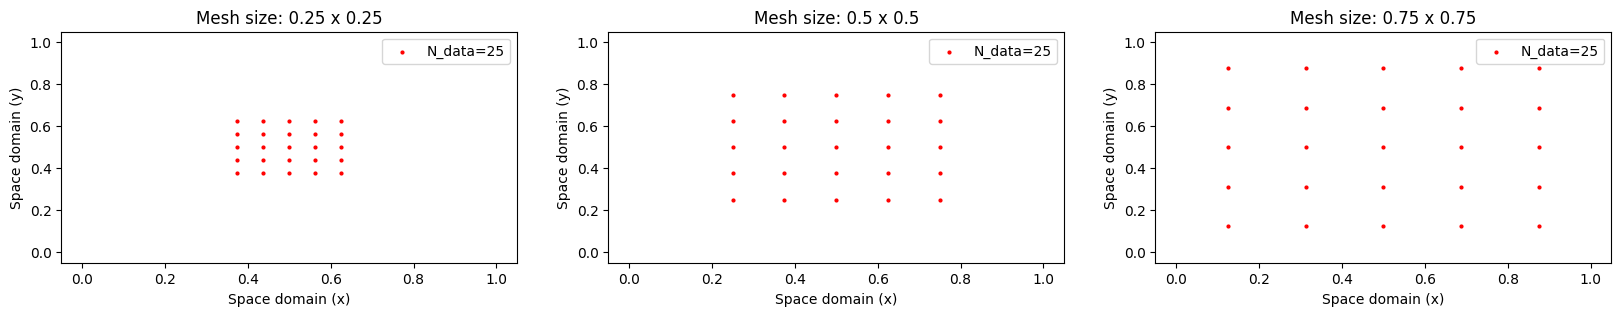

In [9]:
fig, ax = plt.subplots(1, len(mesh_size_list), figsize=(20, 3))
for i, mesh_size in enumerate(mesh_size_list):
    xy_data_mesh, labels_data_mesh = get_ds_data_mesh(pressure_raw_data, velocity_raw_data, mesh_size, 5)
    ax[i].scatter(xy_data_mesh[:,0], xy_data_mesh[:,1], s=4, c='r', label=f'N_data={len(xy_data_mesh)}')
    ax[i].set_xlim([-0.05, 1.05])
    ax[i].set_ylim([-0.05, 1.05])
    ax[i].set_xlabel('Space domain (x)')
    ax[i].set_ylabel('Space domain (y)')
    ax[i].set_title(f"Mesh size: {mesh_size} x {mesh_size}")
    ax[i].legend()
plt.show()

### Modelo PINN

In [10]:
 class PINN_Module(nn.Module):

    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Reynolds = model_parameters["Reynolds"]
        self.InputDimensions = model_parameters["InputDimensions"]
        self.OutputDimensions = model_parameters["OutputDimensions"]
        self.NumberOfNeurons = model_parameters["NumberOfNeurons"]
        self.NumberOfHiddenLayers = model_parameters["NumberOfHiddenLayers"]
        self.ActivationFunction = model_parameters["ActivationFunction"]
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons) for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)
        self.init_xavier()
        
    def init_xavier(self):
        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                m.bias.data.fill_(0)
        self.apply(init_weights)

    def forward(self, x):
        output = self.ActivationFunction(self.InputLayer(x))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        return output

    def pdeResidue(self, X, output):
        # Separate output in u,v and p
        u = output[:,0:1]
        v = output[:,1:2]
        p = output[:,2:3]
        
        # Compute the derivatives of the outputs u,v and p over the inputs (x,y) using AD mechanism:
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        diff_p = torch.autograd.grad(p, X, create_graph=True, grad_outputs=torch.ones_like(p))[0]
        u_x, u_y = diff_u[:, 0:1], diff_u[:, 1:2]
        v_x, v_y = diff_v[:, 0:1], diff_v[:, 1:2]
        p_x, p_y = diff_p[:, 0:1], diff_p[:, 1:2]

        # Compute the second derivative of the outputs u and v over the inputs (x,y) using AD mechanism:
        u_xx = torch.autograd.grad(u_x, X, create_graph=True, grad_outputs=torch.ones_like(u_x))[0][:, 0:1]
        u_yy = torch.autograd.grad(u_y, X, create_graph=True, grad_outputs=torch.ones_like(u_y))[0][:, 1:2]
        v_xx = torch.autograd.grad(v_x, X, create_graph=True, grad_outputs=torch.ones_like(v_x))[0][:, 0:1]
        v_yy = torch.autograd.grad(v_y, X, create_graph=True, grad_outputs=torch.ones_like(v_y))[0][:, 1:2]
        
        # Compute residues
        residue_continuity = u_x + v_y
        residue_momentum_x = u * u_x + v * u_y + p_x - (1/self.Reynolds) * (u_xx + u_yy)
        residue_momentum_y = u * v_x + v * v_y + p_y - (1/self.Reynolds) * (v_xx + v_yy)
        return residue_continuity, residue_momentum_x, residue_momentum_y

    def bcUVResidue(self, X, output):
        # Separate u and v from the output
        u = output[:,0:1]
        v = output[:,1:2]
        # Calculate true bc values 
        u_bc = (X[:,1:2] == 1) * 1.0 # u = 1 only at upper y bound, else 0
        residue_u = u - u_bc
        residue_v = v # v = 0 on all border
        return residue_u, residue_v

    def bcPResidue(self, X, output):
        # Separate p from the output
        p = output[:,2:3]
        residue_p = p # p = 0 on the origin
        return residue_p

### Entrenamiento inverso con datos limpios

In [11]:
# Shared model parameters
model_parameters = {
    "Reynolds": 100,
    "InputDimensions": 2,
    "OutputDimensions": 3,
    "NumberOfNeurons": 100,
    "NumberOfHiddenLayers": 4,
    "ActivationFunction": nn.GELU()
}
epochs = 50_000

In [12]:
def train_step(model, loss_fn, X_pde, X_bc, X_bc_0, X_data, Y_data, Re):
    # PDE
    output_pde = model(X_pde)
    residue_continuity, residue_momentum_x, residue_momentum_y  = model.pdeResidue(X_pde, output_pde)
    loss_pde_continuity = loss_fn(residue_continuity, torch.zeros_like(residue_continuity))
    loss_pde_momentum_x = loss_fn(residue_momentum_x, torch.zeros_like(residue_momentum_x))
    loss_pde_momentum_y = loss_fn(residue_momentum_y, torch.zeros_like(residue_momentum_y))
    loss_pde = loss_pde_continuity + loss_pde_momentum_x * 2 + loss_pde_momentum_y * 2
    
    # BC
    output_bc = model(X_bc)
    residue_u, residue_v = model.bcUVResidue(X_bc, output_bc)
    loss_bc_u = loss_fn(residue_u, torch.zeros_like(residue_u))
    loss_bc_v = loss_fn(residue_v, torch.zeros_like(residue_v))
    output_bc_0 = model(X_bc_0)
    residue_p = model.bcPResidue(X_bc_0, output_bc_0)
    loss_bc_p = loss_fn(residue_p, torch.zeros_like(residue_p))
    loss_bc = loss_bc_u * 10 + loss_bc_v * 10 + loss_bc_p
    
    #Loss data
    y_hat_data = model(X_data)
    loss_data = loss_fn(y_hat_data, Y_data)
    
    return loss_pde, loss_bc, loss_data

Reynolds parameter inverse problem with clean data
------------------------------------------------------------
Mesh size: 0.25 x 0.25


  0%|          | 0/50000 [00:00<?, ?it/s]

Epoch 2500/50000 - Loss Overall: 1.5072e-01, PDE: 4.5147e-02, BC: 1.0345e-01, Data: 2.1283e-03 - Reynolds: 70.66466522216797
Epoch 5000/50000 - Loss Overall: 4.5784e-02, PDE: 8.1881e-03, BC: 3.7303e-02, Data: 2.9291e-04 - Reynolds: 78.02313232421875
Epoch 7500/50000 - Loss Overall: 2.3994e-02, PDE: 3.8475e-03, BC: 2.0065e-02, Data: 8.1377e-05 - Reynolds: 82.49765014648438
Epoch 10000/50000 - Loss Overall: 1.8248e-02, PDE: 3.6694e-03, BC: 1.4488e-02, Data: 9.0196e-05 - Reynolds: 85.9556655883789
Epoch 12500/50000 - Loss Overall: 1.3587e-02, PDE: 3.0345e-03, BC: 1.0496e-02, Data: 5.6803e-05 - Reynolds: 88.12345123291016
Epoch 15000/50000 - Loss Overall: 1.0503e-02, PDE: 1.2480e-03, BC: 9.2334e-03, Data: 2.1374e-05 - Reynolds: 89.67232513427734
Epoch 17500/50000 - Loss Overall: 8.8376e-03, PDE: 1.4293e-03, BC: 7.3898e-03, Data: 1.8547e-05 - Reynolds: 90.92581939697266
Epoch 20000/50000 - Loss Overall: 8.3362e-03, PDE: 1.6780e-03, BC: 6.6458e-03, Data: 1.2348e-05 - Reynolds: 92.00372314453

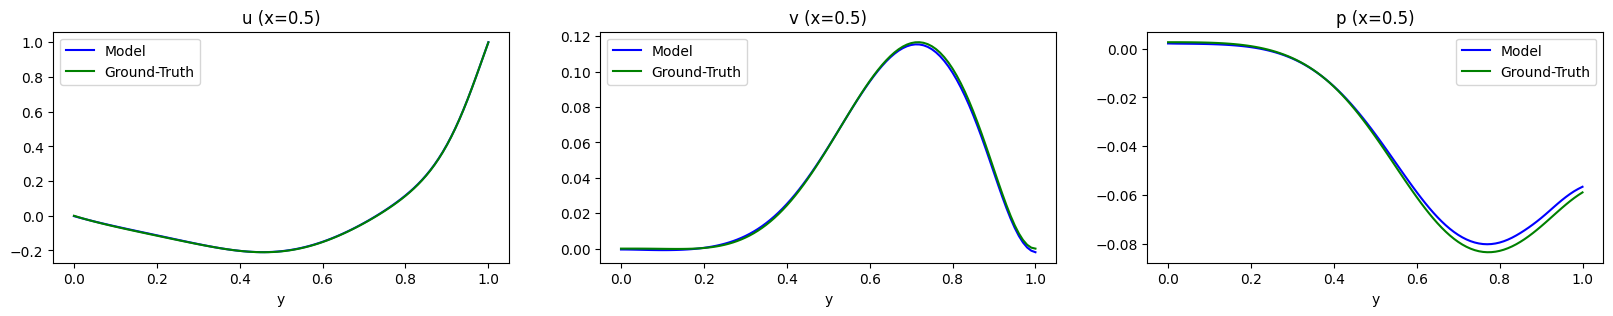

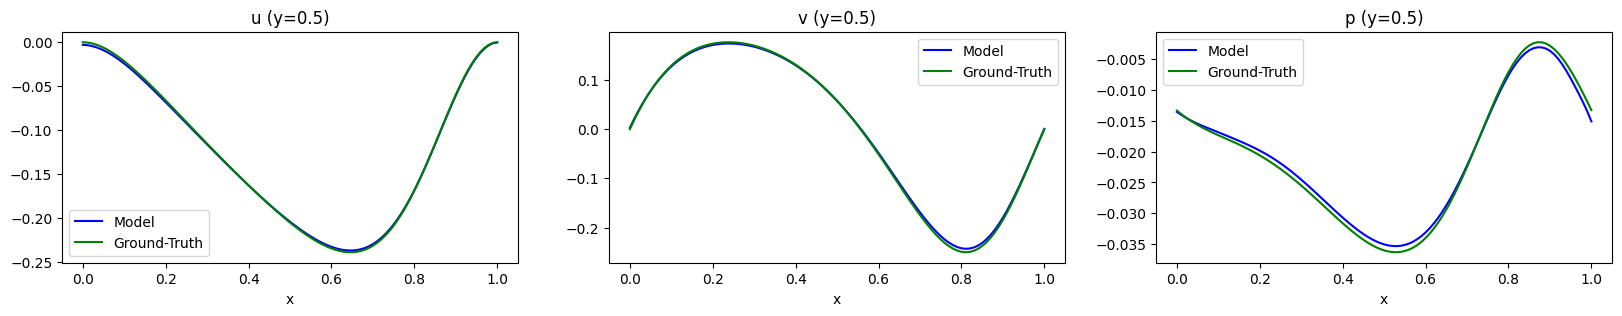

------------------------------------------------------------
Mesh size: 0.5 x 0.5


  0%|          | 0/50000 [00:00<?, ?it/s]

Epoch 2500/50000 - Loss Overall: 1.0395e-01, PDE: 1.6126e-02, BC: 8.5852e-02, Data: 1.9754e-03 - Reynolds: 71.115478515625
Epoch 5000/50000 - Loss Overall: 3.5970e-02, PDE: 6.7923e-03, BC: 2.8970e-02, Data: 2.0772e-04 - Reynolds: 75.66736602783203
Epoch 7500/50000 - Loss Overall: 2.1571e-02, PDE: 4.5490e-03, BC: 1.6938e-02, Data: 8.3895e-05 - Reynolds: 79.54596710205078
Epoch 10000/50000 - Loss Overall: 1.6178e-02, PDE: 4.1612e-03, BC: 1.1922e-02, Data: 9.4734e-05 - Reynolds: 82.3253402709961
Epoch 12500/50000 - Loss Overall: 1.2346e-02, PDE: 2.2864e-03, BC: 9.9470e-03, Data: 1.1236e-04 - Reynolds: 84.17938995361328
Epoch 15000/50000 - Loss Overall: 1.2073e-02, PDE: 2.0419e-03, BC: 9.9196e-03, Data: 1.1110e-04 - Reynolds: 85.71559143066406
Epoch 17500/50000 - Loss Overall: 1.1501e-02, PDE: 3.2766e-03, BC: 8.1795e-03, Data: 4.5012e-05 - Reynolds: 87.05681610107422
Epoch 20000/50000 - Loss Overall: 9.8850e-03, PDE: 2.1602e-03, BC: 7.6565e-03, Data: 6.8386e-05 - Reynolds: 88.2584075927734

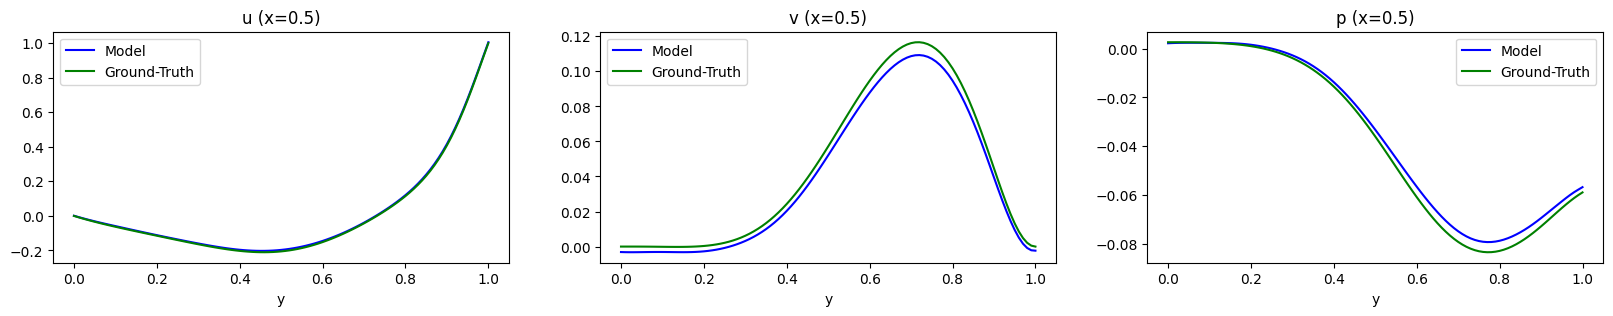

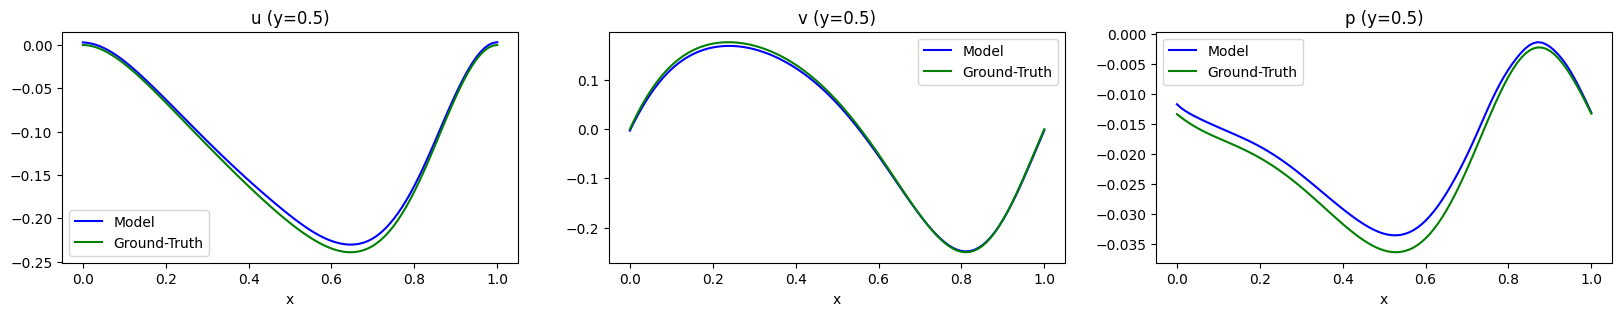

------------------------------------------------------------
Mesh size: 0.75 x 0.75


  0%|          | 0/50000 [00:00<?, ?it/s]

Epoch 2500/50000 - Loss Overall: 1.0817e-01, PDE: 1.5829e-02, BC: 8.9528e-02, Data: 2.8121e-03 - Reynolds: 69.36153411865234
Epoch 5000/50000 - Loss Overall: 4.7496e-02, PDE: 8.1682e-03, BC: 3.8975e-02, Data: 3.5343e-04 - Reynolds: 77.72602081298828
Epoch 7500/50000 - Loss Overall: 2.4764e-02, PDE: 4.0053e-03, BC: 2.0626e-02, Data: 1.3343e-04 - Reynolds: 83.0672836303711
Epoch 10000/50000 - Loss Overall: 2.0484e-02, PDE: 5.6537e-03, BC: 1.4714e-02, Data: 1.1601e-04 - Reynolds: 87.01891326904297
Epoch 12500/50000 - Loss Overall: 1.3838e-02, PDE: 2.1069e-03, BC: 1.1646e-02, Data: 8.5475e-05 - Reynolds: 89.6476058959961
Epoch 15000/50000 - Loss Overall: 1.1266e-02, PDE: 2.1471e-03, BC: 9.0537e-03, Data: 6.5671e-05 - Reynolds: 91.48989868164062
Epoch 17500/50000 - Loss Overall: 1.4586e-02, PDE: 1.3479e-03, BC: 1.3199e-02, Data: 3.9210e-05 - Reynolds: 93.04769897460938
Epoch 20000/50000 - Loss Overall: 8.0031e-03, PDE: 1.0375e-03, BC: 6.9288e-03, Data: 3.6759e-05 - Reynolds: 94.436180114746

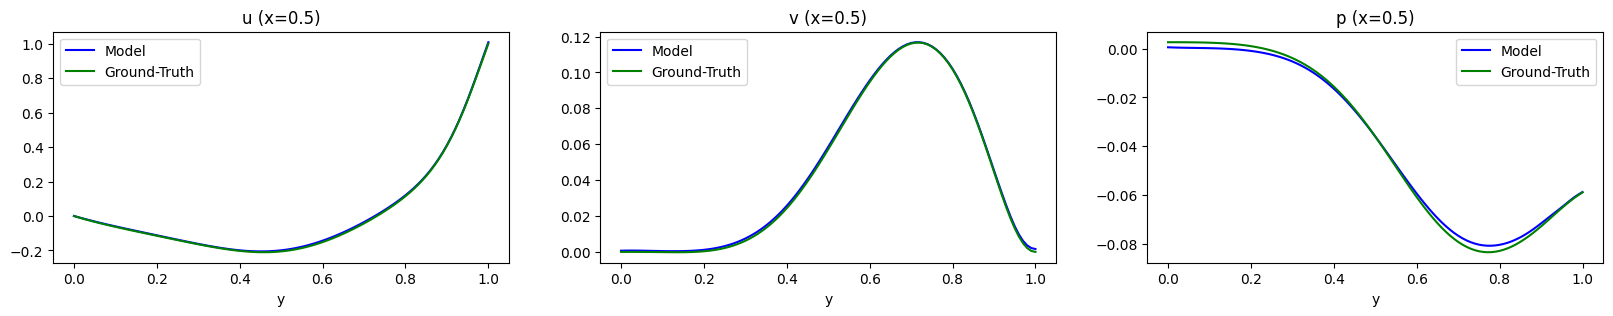

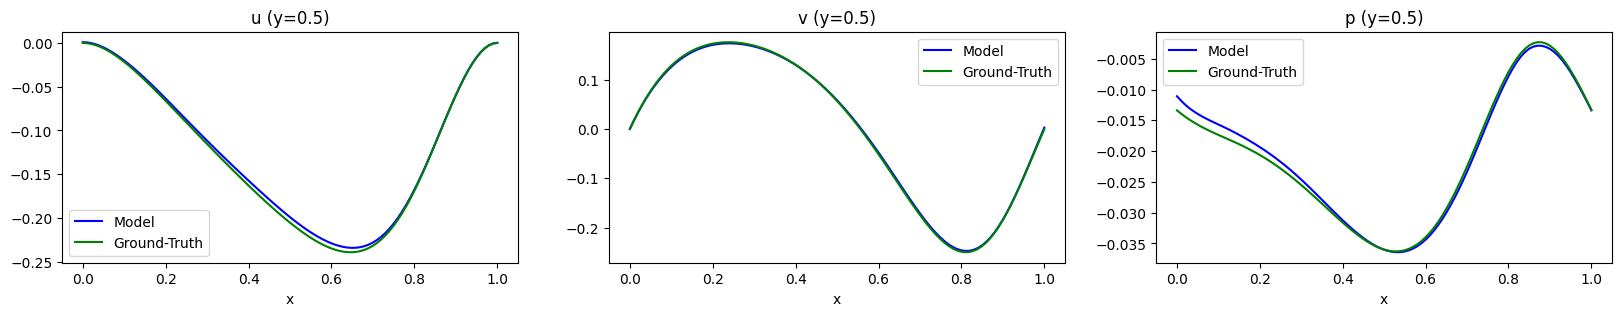

In [13]:
print("Reynolds parameter inverse problem with clean data")

for mesh_size in mesh_size_list:
    # Init
    model = PINN_Module(model_parameters).to(device)
    reynolds = nn.Parameter(torch.tensor([50.0]).to(device))
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam([
        {'params': model.parameters(), 'lr': 1e-3},
        {'params': reynolds, 'lr': 1e-2}])
    model.Reynolds = reynolds
    xy_data_mesh, labels_data_mesh = get_ds_data_mesh(pressure_raw_data, velocity_raw_data, mesh_size, 5)
    X_data = torch.tensor(xy_data_mesh).float().to(device)
    Y_data = torch.tensor(labels_data_mesh).float().to(device)

    # Train
    print("------------------------------------------------------------")
    print(f"Mesh size: {mesh_size} x {mesh_size}")
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss_pde, loss_bc, loss_data = train_step(model, loss_fn, X_pde, X_bc, X_bc_0, X_data, Y_data, reynolds)
        loss_overall = loss_pde + loss_bc + loss_data
        loss_overall.backward()
        optimizer.step()
        if (epoch+1) % (epochs / 20) == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item():.4e}, "
                       f"PDE: {loss_pde.item():.4e}, BC: {loss_bc.item():.4e}, Data: {loss_data.item():.4e} - "
                       f"Reynolds: {reynolds.item()}")
    print(f"Reynolds value: {reynolds.item()}")
    # Calculate error
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_all).float().to(device)
        output_data = model(X_data).cpu().numpy()
    mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
    mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
    mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
    print(f"Error on ground-truth mse_u: {mse_u} | mse_v: {mse_v} | mse_p: {mse_p}")

    # Grafica sobre x=0.5
    mask_x05 = np.where(xy_data_all[:, 0] == 0.5)
    xy_data_x05 = xy_data_all[mask_x05]
    labels_data_x05 = labels_data_all[mask_x05]
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_x05).float().to(device)
        output_data = model(X_data).cpu().numpy()
    fig, ax = plt.subplots(1, 3, figsize=(20, 3))
    for i, title in enumerate(['u', 'v', 'p']):
        ax[i].plot(xy_data_x05[:,1], output_data[:,i], color='blue', label='Model')
        ax[i].plot(xy_data_x05[:,1], labels_data_x05[:,i], color='green', label='Ground-Truth')
        ax[i].set_xlabel('y')
        ax[i].set_title(f"{title} (x=0.5)")
        ax[i].legend()
    plt.show()

    # Grafica sobre y=0.5
    mask_y05 = np.where(xy_data_all[:, 1] == 0.5)
    xy_data_y05 = xy_data_all[mask_y05]
    labels_data_y05 = labels_data_all[mask_y05]
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_y05).float().to(device)
        output_data = model(X_data).cpu().numpy()
    fig, ax = plt.subplots(1, 3, figsize=(20, 3))
    for i, title in enumerate(['u', 'v', 'p']):
        ax[i].plot(xy_data_y05[:,0], output_data[:,i], color='blue', label='Model')
        ax[i].plot(xy_data_y05[:,0], labels_data_y05[:,i], color='green', label='Ground-Truth')
        ax[i].set_xlabel('x')
        ax[i].set_title(f"{title} (y=0.5)")
        ax[i].legend()
    plt.show()

### Entrenamiento inverso con datos con ruido

In [16]:
# Noise percentage
omega = 0.01

Reynolds parameter inverse problem with noisy data
------------------------------------------------------------
Mesh size: 0.25 x 0.25


  0%|          | 0/50000 [00:00<?, ?it/s]

Epoch 2500/50000 - Loss Overall: 9.2020e-02, PDE: 1.7320e-02, BC: 7.3456e-02, Data: 1.2433e-03 - Reynolds: 70.3862075805664
Epoch 5000/50000 - Loss Overall: 3.3248e-02, PDE: 6.3340e-03, BC: 2.6806e-02, Data: 1.0838e-04 - Reynolds: 76.9914779663086
Epoch 7500/50000 - Loss Overall: 2.5291e-02, PDE: 7.4359e-03, BC: 1.7719e-02, Data: 1.3602e-04 - Reynolds: 82.58392333984375
Epoch 10000/50000 - Loss Overall: 1.6979e-02, PDE: 4.1099e-03, BC: 1.2750e-02, Data: 1.1933e-04 - Reynolds: 86.79560852050781
Epoch 12500/50000 - Loss Overall: 1.1894e-02, PDE: 1.6103e-03, BC: 1.0250e-02, Data: 3.3319e-05 - Reynolds: 89.68670654296875
Epoch 15000/50000 - Loss Overall: 9.9835e-03, PDE: 1.4076e-03, BC: 8.5305e-03, Data: 4.5413e-05 - Reynolds: 91.67821502685547
Epoch 17500/50000 - Loss Overall: 8.1993e-03, PDE: 1.1237e-03, BC: 7.0463e-03, Data: 2.9264e-05 - Reynolds: 93.26473999023438
Epoch 20000/50000 - Loss Overall: 8.9732e-03, PDE: 1.5269e-03, BC: 7.4213e-03, Data: 2.5029e-05 - Reynolds: 94.666267395019

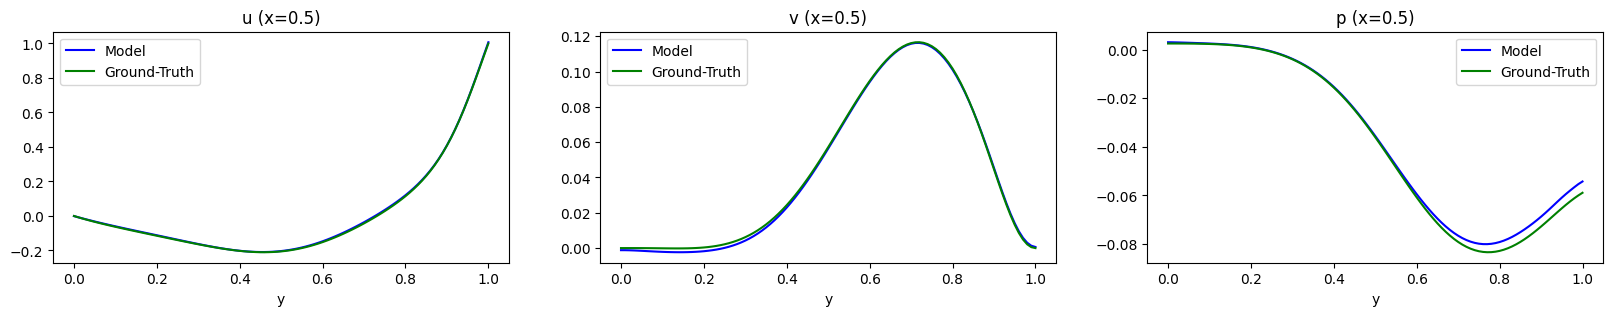

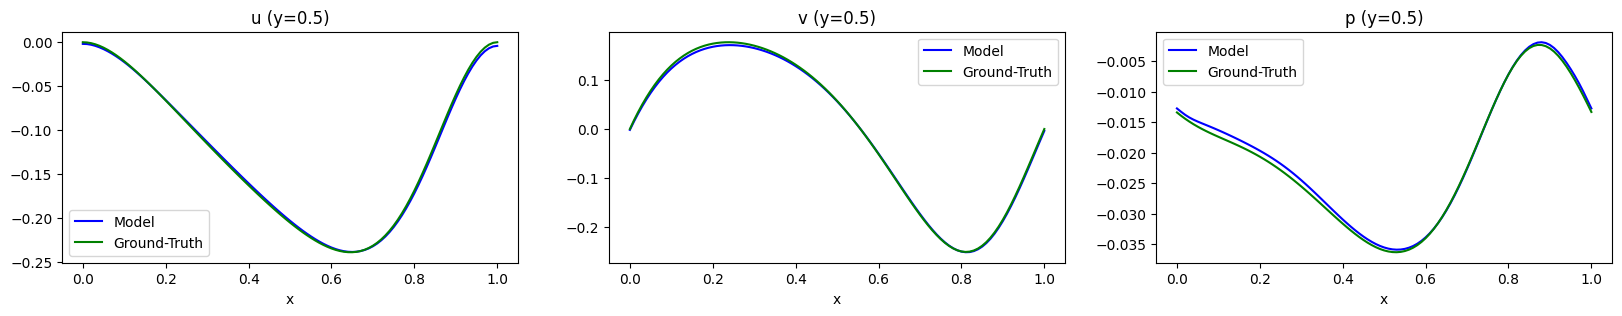

------------------------------------------------------------
Mesh size: 0.5 x 0.5


  0%|          | 0/50000 [00:00<?, ?it/s]

Epoch 2500/50000 - Loss Overall: 1.1305e-01, PDE: 1.9045e-02, BC: 9.0789e-02, Data: 3.2113e-03 - Reynolds: 71.53596496582031
Epoch 5000/50000 - Loss Overall: 6.3412e-02, PDE: 1.4993e-02, BC: 4.7723e-02, Data: 6.9595e-04 - Reynolds: 80.83097076416016
Epoch 7500/50000 - Loss Overall: 2.5291e-02, PDE: 5.4288e-03, BC: 1.9752e-02, Data: 1.0993e-04 - Reynolds: 83.73190307617188
Epoch 10000/50000 - Loss Overall: 2.8559e-02, PDE: 1.0376e-02, BC: 1.8021e-02, Data: 1.6117e-04 - Reynolds: 86.87065887451172
Epoch 12500/50000 - Loss Overall: 1.6256e-02, PDE: 6.4802e-03, BC: 9.7033e-03, Data: 7.2642e-05 - Reynolds: 89.07980346679688
Epoch 15000/50000 - Loss Overall: 1.0569e-02, PDE: 2.0691e-03, BC: 8.4528e-03, Data: 4.7133e-05 - Reynolds: 90.60014343261719
Epoch 17500/50000 - Loss Overall: 9.8426e-03, PDE: 1.8397e-03, BC: 7.9692e-03, Data: 3.3666e-05 - Reynolds: 91.8999252319336
Epoch 20000/50000 - Loss Overall: 9.9028e-03, PDE: 2.6163e-03, BC: 7.2565e-03, Data: 2.9918e-05 - Reynolds: 93.08451843261

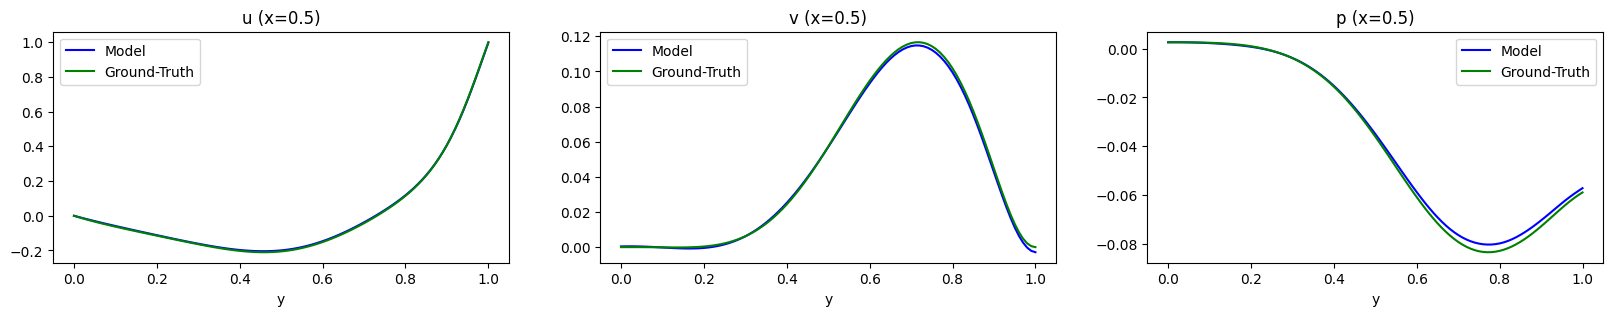

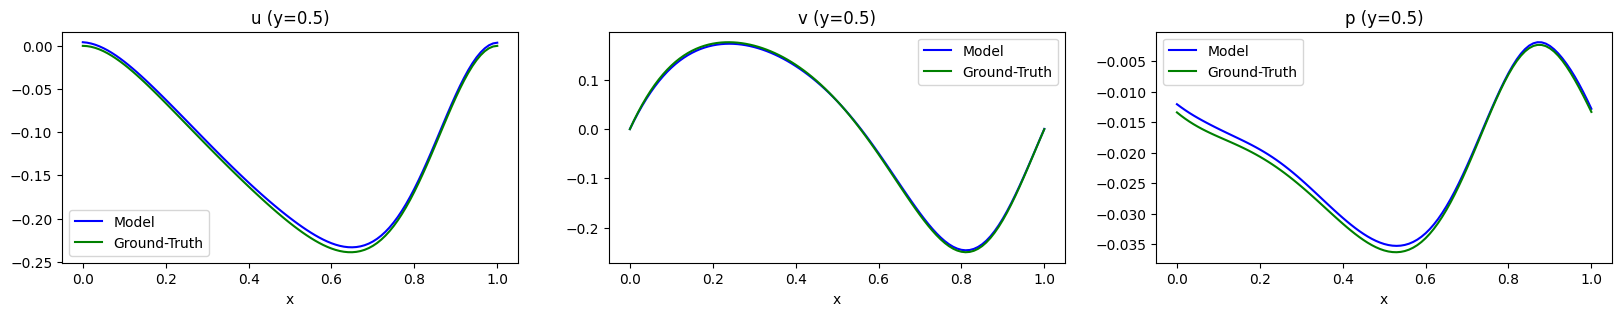

------------------------------------------------------------
Mesh size: 0.75 x 0.75


  0%|          | 0/50000 [00:00<?, ?it/s]

Epoch 2500/50000 - Loss Overall: 1.3312e-01, PDE: 3.2253e-02, BC: 9.6603e-02, Data: 4.2679e-03 - Reynolds: 70.62930297851562
Epoch 5000/50000 - Loss Overall: 4.0929e-02, PDE: 7.3854e-03, BC: 3.3220e-02, Data: 3.2399e-04 - Reynolds: 77.48758697509766
Epoch 7500/50000 - Loss Overall: 2.6937e-02, PDE: 6.4123e-03, BC: 2.0363e-02, Data: 1.6171e-04 - Reynolds: 82.56647491455078
Epoch 10000/50000 - Loss Overall: 1.7327e-02, PDE: 3.5997e-03, BC: 1.3581e-02, Data: 1.4655e-04 - Reynolds: 85.91277313232422
Epoch 12500/50000 - Loss Overall: 1.4322e-02, PDE: 3.1936e-03, BC: 1.1018e-02, Data: 1.1075e-04 - Reynolds: 87.9295425415039
Epoch 15000/50000 - Loss Overall: 1.0355e-02, PDE: 1.6031e-03, BC: 8.6547e-03, Data: 9.7365e-05 - Reynolds: 89.37379455566406
Epoch 17500/50000 - Loss Overall: 9.3782e-03, PDE: 1.7837e-03, BC: 7.5315e-03, Data: 6.3022e-05 - Reynolds: 90.59461212158203
Epoch 20000/50000 - Loss Overall: 1.4413e-02, PDE: 5.5667e-03, BC: 8.7663e-03, Data: 8.0313e-05 - Reynolds: 91.69670867919

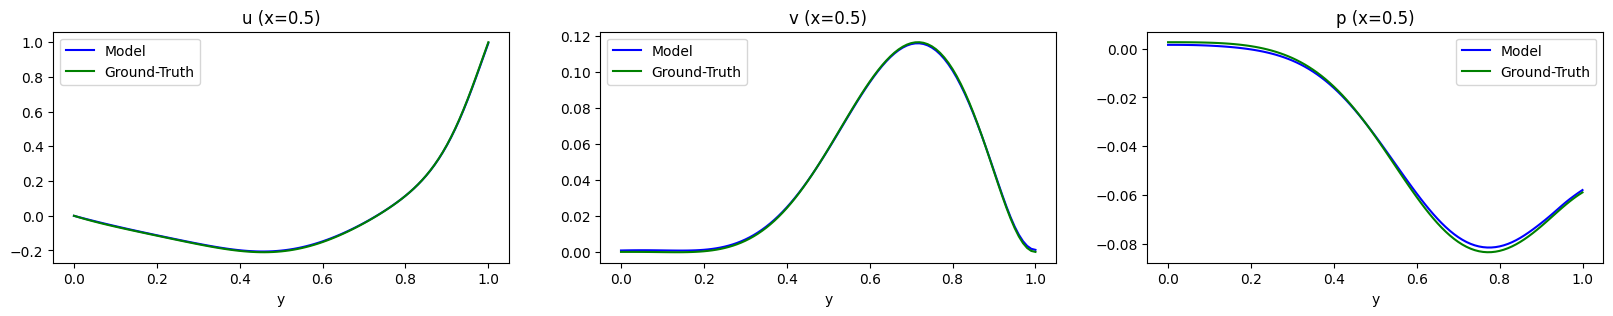

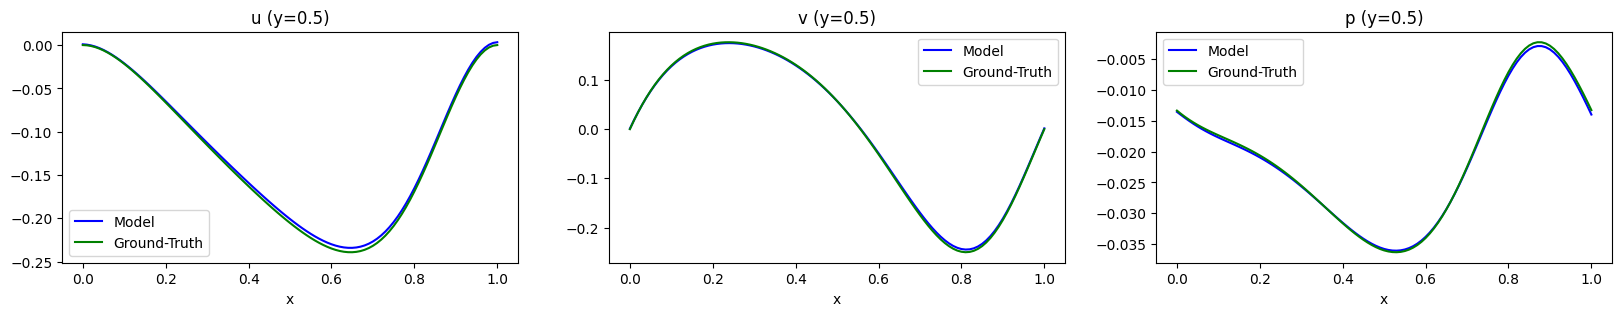

In [17]:
print("Reynolds parameter inverse problem with noisy data")

for mesh_size in mesh_size_list:
    # Init
    model = PINN_Module(model_parameters).to(device)
    reynolds = nn.Parameter(torch.tensor([50.0]).to(device))
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam([
        {'params': model.parameters(), 'lr': 1e-3},
        {'params': reynolds, 'lr': 1e-2}])
    model.Reynolds = reynolds
    xy_data_mesh, labels_data_mesh = get_ds_data_mesh(pressure_raw_data, velocity_raw_data, mesh_size, 5)
    labels_data_mesh = labels_data_mesh + \
        omega * np.max(labels_data_mesh, axis=0)[np.newaxis,:] * np.random.normal(size=(labels_data_mesh.shape))
    X_data = torch.tensor(xy_data_mesh).float().to(device)
    Y_data = torch.tensor(labels_data_mesh).float().to(device)

    # Train
    print("------------------------------------------------------------")
    print(f"Mesh size: {mesh_size} x {mesh_size}")
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss_pde, loss_bc, loss_data = train_step(model, loss_fn, X_pde, X_bc, X_bc_0, X_data, Y_data, reynolds)
        loss_overall = loss_pde + loss_bc + loss_data
        loss_overall.backward()
        optimizer.step()
        if (epoch+1) % (epochs / 20) == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs} - Loss Overall: {loss_overall.item():.4e}, "
                       f"PDE: {loss_pde.item():.4e}, BC: {loss_bc.item():.4e}, Data: {loss_data.item():.4e} - "
                       f"Reynolds: {reynolds.item()}")
    print(f"Reynolds value: {reynolds.item()}")
    # Calculate error
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_all).float().to(device)
        output_data = model(X_data).cpu().numpy()
    mse_u = mean_squared_error(output_data[:,0], labels_data_all[:,0])
    mse_v = mean_squared_error(output_data[:,1], labels_data_all[:,1])
    mse_p = mean_squared_error(output_data[:,2], labels_data_all[:,2])
    print(f"Error on ground-truth mse_u: {mse_u} | mse_v: {mse_v} | mse_p: {mse_p}")

    # Grafica sobre x=0.5
    mask_x05 = np.where(xy_data_all[:, 0] == 0.5)
    xy_data_x05 = xy_data_all[mask_x05]
    labels_data_x05 = labels_data_all[mask_x05]
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_x05).float().to(device)
        output_data = model(X_data).cpu().numpy()
    fig, ax = plt.subplots(1, 3, figsize=(20, 3))
    for i, title in enumerate(['u', 'v', 'p']):
        ax[i].plot(xy_data_x05[:,1], output_data[:,i], color='blue', label='Model')
        ax[i].plot(xy_data_x05[:,1], labels_data_x05[:,i], color='green', label='Ground-Truth')
        ax[i].set_xlabel('y')
        ax[i].set_title(f"{title} (x=0.5)")
        ax[i].legend()
    plt.show()

    # Grafica sobre y=0.5
    mask_y05 = np.where(xy_data_all[:, 1] == 0.5)
    xy_data_y05 = xy_data_all[mask_y05]
    labels_data_y05 = labels_data_all[mask_y05]
    model.train(False)
    with torch.no_grad():
        X_data = torch.tensor(xy_data_y05).float().to(device)
        output_data = model(X_data).cpu().numpy()
    fig, ax = plt.subplots(1, 3, figsize=(20, 3))
    for i, title in enumerate(['u', 'v', 'p']):
        ax[i].plot(xy_data_y05[:,0], output_data[:,i], color='blue', label='Model')
        ax[i].plot(xy_data_y05[:,0], labels_data_y05[:,i], color='green', label='Ground-Truth')
        ax[i].set_xlabel('x')
        ax[i].set_title(f"{title} (y=0.5)")
        ax[i].legend()
    plt.show()

### Conclusiones

- De lo observado, en determinados entrenamientos el valor obtenido del número de Reynolds se acercó al valor esperado. Se observa que el entrenamiento es muy sensible a mínimos locales y a las condiciones iniciales de los parámetros de la red, lo que impide que el modelo converga a valores estables.
- Se estima que con una red mas grande y con mayor cantidad de epochs el valor del número de Reynolds se acercaría establemente al valor real.
- Respecto a la distribución espacial de las muestras, se observa que si se toman valores mas separados, el entrenamiento converge más facilmente y a valores de Reynolds mas cercanos al esperado.
- Respecto a la presencia de ruido, se observa que los valores obtenidos poseen mayor error y que la convergencia de la red a los valores de Reynolds esperados es de mayor dificultad.